# Deep Learning pour Classification

Ce notebook regroupe quelques configurations d'algorithmes de Deep Learning pour la classification de données.

In [1]:
import numpy
import time

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from matplotlib import pyplot



Variable                        Possibilités             Nombre de colonne (+1)
Spécialité de médecins	        33 codes de spécialité	        1-33
Sexe de médecin 	            2	                            34-35
Langue de correspondance 	    2	                            36-37
Université de graduation 	    14 universités	                38-51
Plage horaire de facturation	3 (AM, PM, toute la journée)	52-54
Agence de représentation	    845 codes d’agences             55-899
Établissements                  241 établissements	            900-1140
ActeMedical                     2 (Oui et Non)	                1141-1142
Activités médico-admin          2 (Oui et Non)	                1143-1144
Activités d’enseignement	    2 (Oui et Non)	                1145-1146
Entente LE	                    2 (Oui et Non)	                1147-1148
Activité en santé communautaire	2 (Oui et Non)	                1149-1150
Activité en santé comm. CSST	2 (Oui et Non)	                1151-1152
Activité en santé 

## 1. Enregistrement du jeu de données comportant les données avec étiquettes
Ici, le jeu de données comportant uniquement les données avec des étiquettes de classe est téléchargé. Il est ensuite séparé en jeux d'entraînement et de test en plus d'être normalisé dans toutes les dimensions.

In [2]:
labeledData = numpy.load('labeled.npy')
numberOfData = labeledData.shape[0] # 1441
dimensions = labeledData.shape[1] # 1183

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train = minmax_scale(labeledData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test = minmax_scale(labeledData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

## 2. Déclaration de fonctions utilitaires

In [2]:
def create_balanced_sampler(dataset):
    def make_weights_for_balanced_classes(images, n_classes):                        
        count = [0] * n_classes                                                      
        for item in images:                                                         
            count[int(item[1])] += 1                                                     
        weight_per_class = [0.] * n_classes                                      
        N = float(sum(count))                                                   
        for i in range(n_classes):                                                   
            weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(images)                                              
        for idx, val in enumerate(images):                                          
            weight[idx] = weight_per_class[int(val[1])]                                  
        return weight

    n_classes = numpy.unique(dataset.targets)
    weights = make_weights_for_balanced_classes(dataset.data, len(n_classes))                                                         
    weights = torch.DoubleTensor(weights)                 
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    return sampler

def compute_accuracy(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

## 3. Définition du Dataset sans transformation de la forme des données
Définition de la classe RAMQDataset, une classe qui hérite de la classe abstraite torch.utils.data.Dataset. Comme mentionné dans la documentation, les méthodes __getitem__ et __len__ sont surchargées afin d'avoir un jeu de données utilisable par PyTorch. Le data accepté en paramètres est un array numpy dont la dernière dimension est la valeur de l'étiquette.

In [3]:
class RAMQDataset(Dataset):
    """
    Cette classe sert à définir le dataset RAMQ pour PyTorch
    """

    def __init__(self, data):
        super().__init__()
        self.data = []
        for elem in data:
            if isinstance(elem, numpy.ndarray):
                elem = elem.tolist()
                elem_data = torch.Tensor(elem[:-1])
                elem_target = torch.FloatTensor([elem[-1]])
            # garde les paramètres en mémoire
            self.data += [(elem_data, elem_target[0])]
            
        self.targets = numpy.array(data[:, -1])

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

## 4.1 Déclaration d'un réseau de neurones de base: 1 couche - pour référence

In [4]:
class RAMQNetBase(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self):
        super().__init__()
    
        self.F1 = nn.Linear(1182, 1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.F1(x)
        x = self.output(x)
        return x

## 4.2 Déclaration d'un réseau de neurones de type linéraire: multicouches
Ce réseau est personnalisable à souhait: il est possible d'y indiquer, en paramètres d'entrée, le nombre de dimensions en input, le nombre de couches linéaires à avoir dans le réseau en question et le type de la fonction d'activation qui y sera relié.

In [5]:
class RAMQNetLinear(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self, n_inputs, n_layers, activation = nn.ELU()):
        super().__init__()
        
        reduction_ratio = (1/n_inputs)**(1/n_layers)
        
        layers = []
        layer_lenght = n_inputs
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until 1])
        while layer_lenght > 1:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(1)
        
        # Build network layers
        network_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            layer = nn.Linear(layers[i], layers[i+1])
            network_layers.append(layer)
            network_layers.append(activation)
            network_layers.append(nn.BatchNorm1d(layers[i+1]))
        network_layers[-1] = nn.Sigmoid()
            
        # Build pytorch sequential network
        self.network = nn.Sequential(
            *network_layers
        )
        
    def forward(self, x):

        # Exécute l'inférence du réseau. L'ordre 
        # d'exécution ici est important.
        x = self.network(x)
        
        return x

## 5. Déclaration de la fonction permettant l'affichage du pourcentage d'efficacité en classement selon 1 à 9 couches d'un réseau de neurones "x"
Cette méthode n'a besoin, en entrées, que d'un tableau des pourcentages d'efficacité pour 0 à 9 couches.

In [6]:
def plot_results(test_accu, start, end):
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_accu, label='Test accuracy')
    ax.set_xlim(start, end)
    pyplot.grid()

    pyplot.show()

## 6. Déclaration de la fonction permettant la classification par réseau de neurones profond de type multicouches linéaire
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

In [7]:
def compute_linear_results(X_train, X_test):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cpu" 

    # Définit les paramètres d'entraînement 
    nb_epoch = 250
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32
    
    # Définit le nombre de dimensions des données avec lesquelles on travaille (la dernière dimension étant l'étiquette)
    dimensions = X_train.shape[1] - 1  

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)

    test_accu = []
    test_accu.append(0)

    # Instancier un réseau RAMQNetLinear
    # dans une variable nommée "model"
    for i in range(1,10):
        print("Je vais utiliser " + str(i) + " layers")
        model = RAMQNetLinear(dimensions, i)

        # Tranfert le réseau au bon endroit
        model.to(device)

        # Instancier une fonction d'erreur BinaryCrossEntropy
        # et la mettre dans une variable nommée criterion
        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        # Ne pas oublier de lui donner les hyperparamètres
        # d'entraînement : learning rate et momentum!
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()

        for i_epoch in range(nb_epoch):

            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer
                # une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

        # affiche le score à l'écran
        test_acc = compute_accuracy(model, test_loader, device)
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        test_accu.append(test_acc)
    plot_results(test_accu, 1, 9)

## 7. Calcul du taux de réussite en classement d'un SVM linéaire de base sur les données non réduites - pour référence

In [17]:
# Linear SVM performance with all dimensions
clf = LinearSVC()
clf.fit(X_train[:, : -1], X_train[:, -1])
score = clf.score(X_test[:, : -1], X_test[:, -1])
print("Score on all dimensions:", score)

Score on all dimensions: 0.8361111111111111


Lorsque l'on tente de classifier les 1441 données à 1182 dimensions avec un réseau de neurones à 1 couche linéaire, on obtient un pourcentage de classement de l'ordre d'environ 82%.

## 8. Calcul du taux de réussite en classement d'un réseau linéaire multicouches sur les données non réduites - pour référence

Je vais utiliser 1 layers
 [-] epoch    1/250, train loss 0.686894 in 0.03s
 [-] epoch    2/250, train loss 0.658042 in 0.03s
 [-] epoch    3/250, train loss 0.630507 in 0.02s
 [-] epoch    4/250, train loss 0.617247 in 0.03s
 [-] epoch    5/250, train loss 0.598471 in 0.03s
 [-] epoch    6/250, train loss 0.585760 in 0.03s
 [-] epoch    7/250, train loss 0.585472 in 0.03s
 [-] epoch    8/250, train loss 0.578508 in 0.03s
 [-] epoch    9/250, train loss 0.559436 in 0.03s
 [-] epoch   10/250, train loss 0.566538 in 0.03s
 [-] epoch   11/250, train loss 0.546757 in 0.03s
 [-] epoch   12/250, train loss 0.543458 in 0.03s
 [-] epoch   13/250, train loss 0.539289 in 0.03s
 [-] epoch   14/250, train loss 0.532973 in 0.02s
 [-] epoch   15/250, train loss 0.528345 in 0.03s
 [-] epoch   16/250, train loss 0.514023 in 0.03s
 [-] epoch   17/250, train loss 0.529386 in 0.03s
 [-] epoch   18/250, train loss 0.517567 in 0.04s
 [-] epoch   19/250, train loss 0.519313 in 0.03s
 [-] epoch   20/250, tra

 [-] epoch   76/250, train loss 0.333345 in 0.08s
 [-] epoch   77/250, train loss 0.311390 in 0.07s
 [-] epoch   78/250, train loss 0.329150 in 0.07s
 [-] epoch   79/250, train loss 0.329106 in 0.07s
 [-] epoch   80/250, train loss 0.360876 in 0.07s
 [-] epoch   81/250, train loss 0.333102 in 0.06s
 [-] epoch   82/250, train loss 0.335034 in 0.08s
 [-] epoch   83/250, train loss 0.334150 in 0.08s
 [-] epoch   84/250, train loss 0.321516 in 0.07s
 [-] epoch   85/250, train loss 0.308439 in 0.07s
 [-] epoch   86/250, train loss 0.342272 in 0.08s
 [-] epoch   87/250, train loss 0.315602 in 0.07s
 [-] epoch   88/250, train loss 0.310725 in 0.07s
 [-] epoch   89/250, train loss 0.285735 in 0.07s
 [-] epoch   90/250, train loss 0.315211 in 0.07s
 [-] epoch   91/250, train loss 0.354974 in 0.07s
 [-] epoch   92/250, train loss 0.318265 in 0.07s
 [-] epoch   93/250, train loss 0.321508 in 0.07s
 [-] epoch   94/250, train loss 0.317926 in 0.07s
 [-] epoch   95/250, train loss 0.306919 in 0.08s


 [-] epoch  151/250, train loss 0.234843 in 0.13s
 [-] epoch  152/250, train loss 0.266849 in 0.14s
 [-] epoch  153/250, train loss 0.239830 in 0.13s
 [-] epoch  154/250, train loss 0.241307 in 0.13s
 [-] epoch  155/250, train loss 0.242555 in 0.13s
 [-] epoch  156/250, train loss 0.246355 in 0.14s
 [-] epoch  157/250, train loss 0.228121 in 0.13s
 [-] epoch  158/250, train loss 0.232341 in 0.11s
 [-] epoch  159/250, train loss 0.233410 in 0.13s
 [-] epoch  160/250, train loss 0.235731 in 0.13s
 [-] epoch  161/250, train loss 0.254208 in 0.14s
 [-] epoch  162/250, train loss 0.249817 in 0.12s
 [-] epoch  163/250, train loss 0.239944 in 0.12s
 [-] epoch  164/250, train loss 0.234931 in 0.13s
 [-] epoch  165/250, train loss 0.231438 in 0.11s
 [-] epoch  166/250, train loss 0.222969 in 0.13s
 [-] epoch  167/250, train loss 0.222429 in 0.13s
 [-] epoch  168/250, train loss 0.206306 in 0.14s
 [-] epoch  169/250, train loss 0.231362 in 0.11s
 [-] epoch  170/250, train loss 0.235616 in 0.13s


 [-] epoch  226/250, train loss 0.202808 in 0.19s
 [-] epoch  227/250, train loss 0.209161 in 0.22s
 [-] epoch  228/250, train loss 0.212249 in 0.22s
 [-] epoch  229/250, train loss 0.214586 in 0.21s
 [-] epoch  230/250, train loss 0.209930 in 0.21s
 [-] epoch  231/250, train loss 0.212893 in 0.20s
 [-] epoch  232/250, train loss 0.198827 in 0.19s
 [-] epoch  233/250, train loss 0.208853 in 0.22s
 [-] epoch  234/250, train loss 0.210772 in 0.20s
 [-] epoch  235/250, train loss 0.217120 in 0.20s
 [-] epoch  236/250, train loss 0.217848 in 0.22s
 [-] epoch  237/250, train loss 0.208374 in 0.21s
 [-] epoch  238/250, train loss 0.213925 in 0.21s
 [-] epoch  239/250, train loss 0.214252 in 0.20s
 [-] epoch  240/250, train loss 0.208597 in 0.22s
 [-] epoch  241/250, train loss 0.200781 in 0.19s
 [-] epoch  242/250, train loss 0.202604 in 0.21s
 [-] epoch  243/250, train loss 0.219412 in 0.20s
 [-] epoch  244/250, train loss 0.201550 in 0.22s
 [-] epoch  245/250, train loss 0.243404 in 0.20s


 [-] epoch   50/250, train loss 0.271757 in 0.41s
 [-] epoch   51/250, train loss 0.308569 in 0.43s
 [-] epoch   52/250, train loss 0.268918 in 0.43s
 [-] epoch   53/250, train loss 0.272214 in 0.40s
 [-] epoch   54/250, train loss 0.263229 in 0.41s
 [-] epoch   55/250, train loss 0.256736 in 0.41s
 [-] epoch   56/250, train loss 0.253083 in 0.38s
 [-] epoch   57/250, train loss 0.247069 in 0.42s
 [-] epoch   58/250, train loss 0.265275 in 0.44s
 [-] epoch   59/250, train loss 0.270713 in 0.38s
 [-] epoch   60/250, train loss 0.276519 in 0.40s
 [-] epoch   61/250, train loss 0.248532 in 0.41s
 [-] epoch   62/250, train loss 0.247417 in 0.42s
 [-] epoch   63/250, train loss 0.280878 in 0.40s
 [-] epoch   64/250, train loss 0.253168 in 0.44s
 [-] epoch   65/250, train loss 0.256112 in 0.42s
 [-] epoch   66/250, train loss 0.254210 in 0.40s
 [-] epoch   67/250, train loss 0.247717 in 0.41s
 [-] epoch   68/250, train loss 0.259737 in 0.38s
 [-] epoch   69/250, train loss 0.243274 in 0.40s


 [-] epoch  125/250, train loss 0.239737 in 0.51s
 [-] epoch  126/250, train loss 0.222563 in 0.49s
 [-] epoch  127/250, train loss 0.212647 in 0.48s
 [-] epoch  128/250, train loss 0.228657 in 0.49s
 [-] epoch  129/250, train loss 0.220578 in 0.47s
 [-] epoch  130/250, train loss 0.223361 in 0.47s
 [-] epoch  131/250, train loss 0.209026 in 0.46s
 [-] epoch  132/250, train loss 0.206038 in 0.47s
 [-] epoch  133/250, train loss 0.210330 in 0.49s
 [-] epoch  134/250, train loss 0.207651 in 0.50s
 [-] epoch  135/250, train loss 0.206162 in 0.50s
 [-] epoch  136/250, train loss 0.204399 in 0.49s
 [-] epoch  137/250, train loss 0.207253 in 0.49s
 [-] epoch  138/250, train loss 0.195897 in 0.47s
 [-] epoch  139/250, train loss 0.251061 in 0.46s
 [-] epoch  140/250, train loss 0.219254 in 0.48s
 [-] epoch  141/250, train loss 0.212212 in 0.48s
 [-] epoch  142/250, train loss 0.206394 in 0.47s
 [-] epoch  143/250, train loss 0.214266 in 0.49s
 [-] epoch  144/250, train loss 0.216988 in 0.49s


 [-] epoch  200/250, train loss 0.214673 in 0.58s
 [-] epoch  201/250, train loss 0.214800 in 0.58s
 [-] epoch  202/250, train loss 0.208075 in 0.59s
 [-] epoch  203/250, train loss 0.226570 in 0.58s
 [-] epoch  204/250, train loss 0.221069 in 0.61s
 [-] epoch  205/250, train loss 0.213942 in 0.59s
 [-] epoch  206/250, train loss 0.215976 in 0.60s
 [-] epoch  207/250, train loss 0.208525 in 0.61s
 [-] epoch  208/250, train loss 0.237495 in 0.59s
 [-] epoch  209/250, train loss 0.211913 in 0.57s
 [-] epoch  210/250, train loss 0.239292 in 0.59s
 [-] epoch  211/250, train loss 0.200678 in 0.59s
 [-] epoch  212/250, train loss 0.224072 in 0.59s
 [-] epoch  213/250, train loss 0.227767 in 0.60s
 [-] epoch  214/250, train loss 0.202910 in 0.56s
 [-] epoch  215/250, train loss 0.209129 in 0.61s
 [-] epoch  216/250, train loss 0.206841 in 0.58s
 [-] epoch  217/250, train loss 0.210480 in 0.59s
 [-] epoch  218/250, train loss 0.203098 in 0.57s
 [-] epoch  219/250, train loss 0.192173 in 0.59s


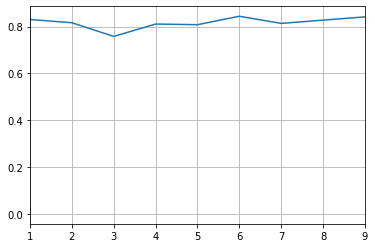

In [18]:
compute_linear_results(X_train, X_test) # all dimensions

## 9. Calcul du taux de réussite en classement d'un réseau linéaire multicouches sur les données réduites
Cette deuxième étape consiste à avoir les résultats sur les dimensions réduites engendrées par la réduction de dimensionnalité.

In [9]:
reducedData = numpy.load('labeled_reduit_100dim.npy')
numberOfData = reducedData.shape[0]
dimensions = reducedData.shape[1]

#print(numberOfData, dimensions)

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train_reduced = minmax_scale(reducedData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test_reduced = minmax_scale(reducedData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

In [ ]:
compute_linear_results(X_train_reduced, X_test_reduced)

Classification avec fonction d'activation elu à 9 couches: +- 70% de taux de réussite

Classification avec fonction d'activation relu à 9 couches: +- 50% de taux de réussite

Tenir compte du fait que l'on n'a pas beaucoup de données considérant le nombre de dimensions

## 10. Expérimentations - Déclaration d'un réseau de neurones de type convolution
Cette partie agit à titre d'expérimentation.

Le réseau de neurones à convolution est facile à paramétrer: il est possible d'y indiquer, en paramètres d'entrée, le nombre de dimensions en input, le nombre de convolutions à avoir dans le réseau en question et le type de la fonction d'activation qui y sera relié.

In [10]:
class RAMQNetConvolution(nn.Module):
    """
    Cette classe définit un réseau par convolution permettant de classifier des données de la RAMQ
    """

    def __init__(self, numberOfFilters):
        super().__init__()
        
        self.numberOfFilters = numberOfFilters
        
        self.C1 = nn.Conv1d(1, 32, kernel_size=251, stride=2, padding=125, bias=False)
        self.B1 = nn.BatchNorm1d(32)
        self.C2 = nn.Conv1d(32, 64, kernel_size=175, stride=2, padding=87, bias=False)
        
        self.B = nn.BatchNorm1d(64)
        
        self.C = nn.Conv1d(64, 64, kernel_size=175, stride=2, padding=87, bias=False)
        
        self.activation = nn.ELU()
        self.F1 = nn.Linear(64, 1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        # Sélectionne la taille batch à l'entrée
        batch_size = x.shape[0]

        x = self.activation(self.B1(self.C1(x)))
        x = self.activation(self.B(self.C2(x)))
        
        for i in range(self.numberOfFilters):
            x = self.activation(self.B(self.C(x)))
        
        # Fait un average pooling sur les caractéristiques
        # de chaque filtre
        x = x.view(batch_size, 64, -1).mean(dim=2)
        
        # Couche lineaire et sigmoide
        x = self.F1(x)
        x = self.output(x)
        
        return x

## 11. Déclaration de la fonction permettant la classification par réseau de neurones profond de type convolution
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

In [ ]:
def compute_accuracy_for_convolution(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        values, targets = batch
        values = values.unsqueeze(1)
        values = values.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(values)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

def compute_convolution_results(X_train, X_test):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Définit les paramètres d'entraînement 
    nb_epoch = 10
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)
    
    test_accu = []
    test_accu.append(0)
    test_accu.append(0)
    test_accu.append(0)
    test_accu.append(0)
    test_accu.append(0)
    test_accu.append(0)
    
    for i in range(1, 10):
        print("Je vais ajouter " + str(i) + " filters")
        
        # Instancier un réseau RAMQNetConvolution
        # dans une variable nommée "model"
        model = RAMQNetConvolution(i)
        model.to(device)

        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()

        for i_epoch in range(nb_epoch):

            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch

                values = values.unsqueeze(1)
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

        # affiche le score à l'écran
        test_acc = compute_accuracy_for_convolution(model, test_loader, device)
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        test_accu.append(test_acc)
    plot_results(test_accu, 1, 10)

## 12. Calcul du taux de réussite en classement d'un réseau de convolution sur les données non réduites - référence

Je vais ajouter 6 filters
 [-] epoch    1/10, train loss 0.484058 in 4.02s
 [-] epoch    2/10, train loss 0.381153 in 3.96s
 [-] epoch    3/10, train loss 0.364269 in 4.00s
 [-] epoch    4/10, train loss 0.306918 in 4.01s
 [-] epoch    5/10, train loss 0.278638 in 4.04s
 [-] epoch    6/10, train loss 0.272154 in 4.03s
 [-] epoch    7/10, train loss 0.286477 in 4.03s
 [-] epoch    8/10, train loss 0.253794 in 4.01s
 [-] epoch    9/10, train loss 0.275955 in 4.03s
 [-] epoch   10/10, train loss 0.255494 in 4.04s
 [-] test acc. 82.777778%
Je vais ajouter 7 filters
 [-] epoch    1/10, train loss 0.524414 in 4.28s
 [-] epoch    2/10, train loss 0.406604 in 4.29s
 [-] epoch    3/10, train loss 0.385529 in 4.30s
 [-] epoch    4/10, train loss 0.335149 in 4.31s
 [-] epoch    5/10, train loss 0.304158 in 4.33s
 [-] epoch    6/10, train loss 0.285415 in 4.32s
 [-] epoch    7/10, train loss 0.303692 in 4.32s
 [-] epoch    8/10, train loss 0.293430 in 4.35s
 [-] epoch    9/10, train loss 0.240349 

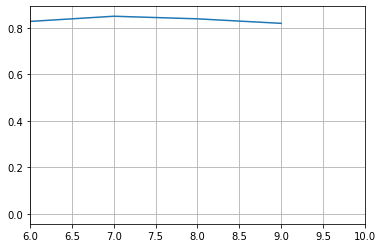

In [155]:
compute_convolution_results(X_train, X_test)

In [14]:
compute_convolution_results(X_train_reduced, X_test_reduced)

Je vais ajouter 1 filters
 [-] epoch    1/50, train loss 0.644824 in 3.62s
 [-] epoch    2/50, train loss 0.623846 in 3.55s
 [-] epoch    3/50, train loss 0.609674 in 3.64s
 [-] epoch    4/50, train loss 0.591891 in 4.23s
 [-] epoch    5/50, train loss 0.569576 in 4.30s
 [-] epoch    6/50, train loss 0.568190 in 3.67s
 [-] epoch    7/50, train loss 0.534449 in 4.10s
 [-] epoch    8/50, train loss 0.550036 in 3.78s
 [-] epoch    9/50, train loss 0.563778 in 3.72s


KeyboardInterrupt: 